In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import os
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

In [2]:
dir_path = os.path.join("..", "data", "raw")
dir_to_save = os.path.join("..", "data", "interim")
building_metadata = "building_metadata.csv"
weather_train = "weather_train.csv"
train = "train.csv"

In [3]:
metadata = pd.read_csv(os.path.join(dir_path, building_metadata))
weather_train = pd.read_csv(os.path.join(dir_path, weather_train))
train = pd.read_csv(os.path.join(dir_path, train))

In [4]:
train = train.merge(metadata, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')
#del weather_train, metadata
#gc.collect();

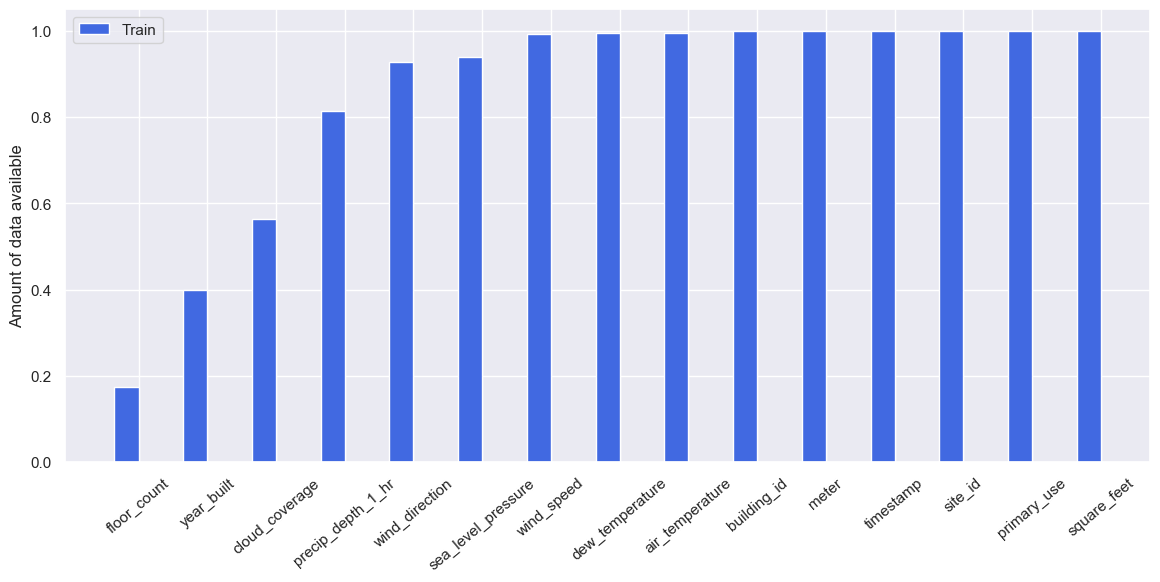

In [5]:
train_data = (train.count() / len(train)).drop('meter_reading').sort_values().values
ind = np.arange(len(train_data))
width = 0.35

fig, axes = plt.subplots(1,1,figsize=(14, 6), dpi=100)
tr = axes.bar(ind, train_data, width, color='royalblue')


axes.set_ylabel('Amount of data available');
axes.set_xticks(ind + width / 2)
axes.set_xticklabels((train.count() / len(train)).drop('meter_reading').sort_values().index, rotation=40)
axes.legend([tr], ['Train']);

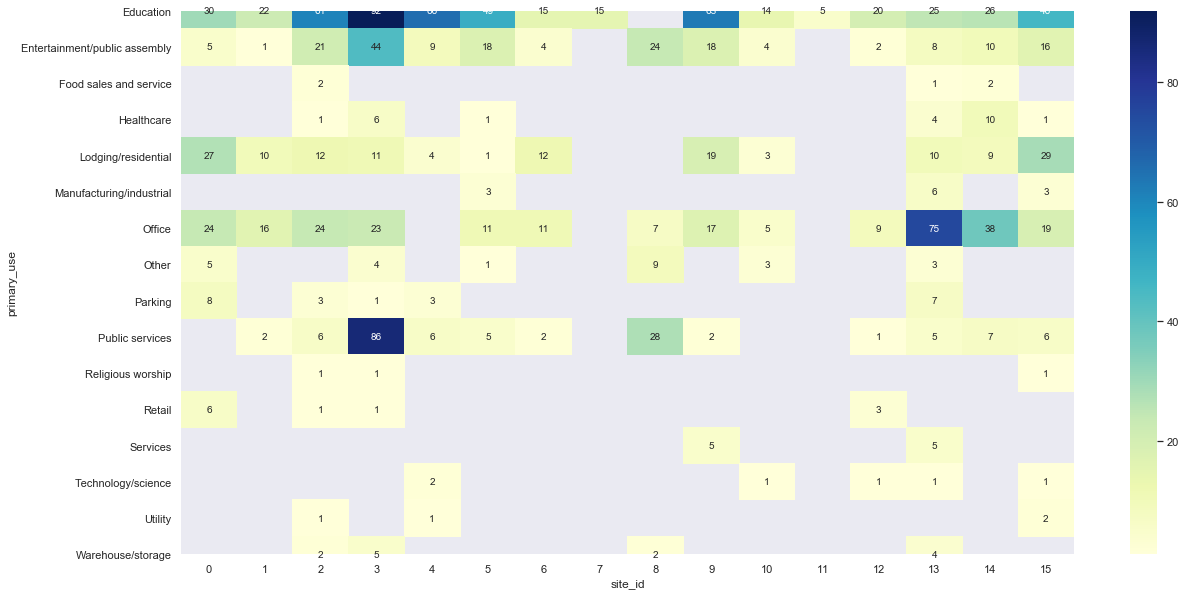

In [6]:
building_counts = train.groupby(['primary_use', 'site_id']).building_id.nunique().to_frame('counts')
building_counts = building_counts.reset_index().pivot(index='primary_use', columns='site_id', values='counts')

fig, ax = plt.subplots(figsize=(20,10))
distribution = sns.heatmap(building_counts, annot=True, cmap='YlGnBu',
                xticklabels=building_counts.columns.values,
                yticklabels=building_counts.index.values)
distribution.figure.savefig("building_distribution.png")

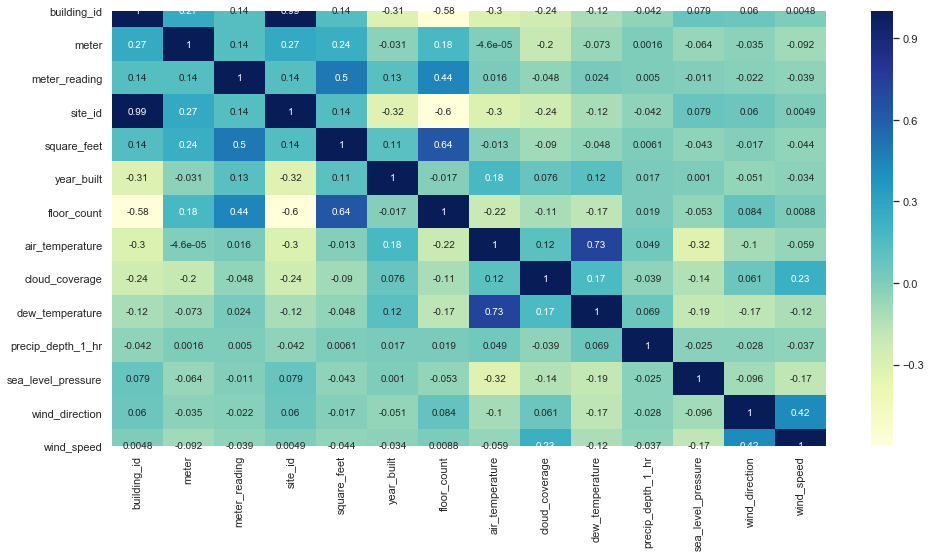

In [7]:
fig, ax = plt.subplots(figsize=(16,8))

corr = train[[col for col in train.columns if col != 'year']].sample(100100).corr(method='spearman')
spearman = sns.heatmap(corr, annot=True, cmap='YlGnBu',
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
spearman.figure.savefig("Corr_Spearman.png")

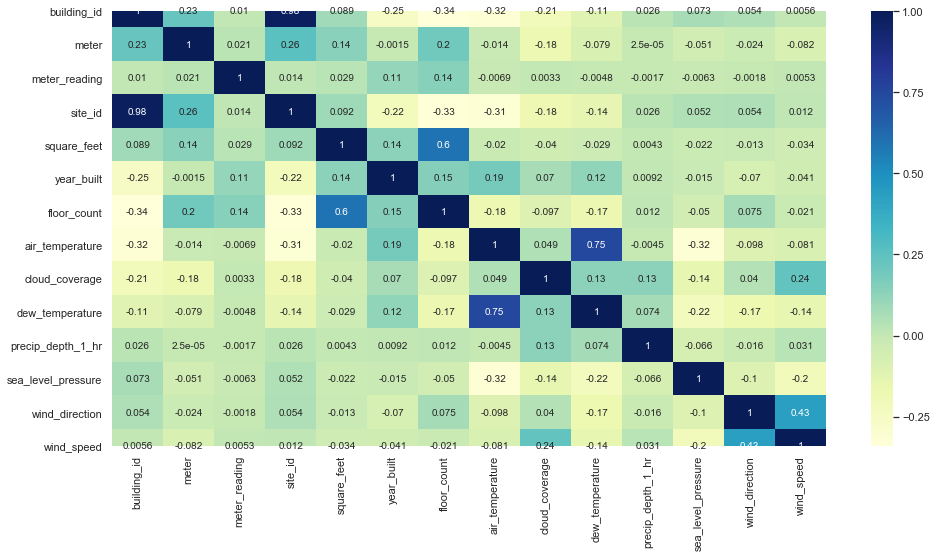

In [8]:
fig, ax = plt.subplots(figsize=(16,8))

corr = train[[col for col in train.columns if col != 'year']].sample(100100).corr(method='pearson')
pearson = sns.heatmap(corr, annot=True, cmap='YlGnBu',
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
pearson.figure.savefig("Corr_pearson.png")